In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from pmsm_tools import phi_eval_2,i_eval_2,phi_eval_3,park_2,ipark_2
import scipy.io as sio

In [2]:
%matplotlib widget

In [3]:
data_i2p = np.load('pmsm_i2phi.npz')

Phi_d_i2p,Phi_q_i2p = data_i2p['phi_d'],data_i2p['phi_q']
I_d_i2p,I_q_i2p = data_i2p['i_d'].astype(np.float64),data_i2p['i_q'].astype(np.float64)
Theta_i2p = data_i2p['theta'].astype(np.float64)
Torque_i2p = data_i2p['torque']

## Classical model parameters

In [4]:
Phi_m = Phi_d_i2p[10,10,0]
L_d = (Phi_d_i2p[11,10,0]-Phi_d_i2p[9,10,0])/(I_d_i2p[11]-I_d_i2p[9])
L_q = (Phi_q_i2p[10,11,0]-Phi_q_i2p[10,9,0])/(I_q_i2p[11]-I_q_i2p[9])
R_s = 0.07
N_pp = 4

R_l = 10.0

omega_r = 7200*2*np.pi/60 #3000*2*np.pi/60/N_pp

## Classic linear model with currents as states

In [50]:
Dt = 1.0e-6
times = np.arange(0.0,0.02,Dt)
N_t = len(times)
Z_1 = {'t':times}
Z_1.update({'v_dqz':np.zeros((N_t,3)),'i_dqz':np.zeros((N_t,3)),'i_dqz_ctrl':np.zeros((N_t,3))})
Z_1.update({'v_abc':np.zeros((N_t,3)),'tau_e':np.zeros(N_t)})
v_dqz = np.zeros((3))
v_abc = np.zeros((3))
i_dqz = np.zeros((3))
i_dqz_ctrl = np.zeros((3))
v_abc_ctrl = np.zeros((3))
v_dqz_ctrl = np.zeros((3))

i_d,i_q = 0.0,0.0
v_d,v_q = 0.0,0.0
theta_e = 0.0
tau_e = 0.0
xi_id,xi_iq = 0.0,0.0

K_p = L_d/100e-6
T_pi = L_d/R_s

i_d_ref = 0.0
i_q_ref = 20.0

for it,t in enumerate(times):

    # recording
    Z_1['v_dqz'][it,:]= v_dqz
    Z_1['i_dqz'][it,:]= i_dqz
    Z_1['i_dqz_ctrl'][it,:]= i_dqz_ctrl
    Z_1['tau_e'][it] = tau_e
    Z_1['v_abc'][it,:] = v_abc

    # model
    v_dqz_ctrl = park_2(v_abc_ctrl,theta_e)
    v_d = v_dqz_ctrl[0]
    v_q = v_dqz_ctrl[1]
    
    omega_e = omega_r*N_pp
    
    dtheta_e = omega_e
    di_d = 1/L_d*(v_d - R_s*i_d - omega_e*L_q*i_q)
    di_q = 1/L_q*(v_q - R_s*i_q + omega_e*(Phi_m + L_d*i_d))
    tau_e = 3/2*N_pp*(Phi_m*i_q + (L_d - L_q)*i_d*i_q)
                     
    v_dqz[0],v_dqz[1],v_dqz[2] = v_d,v_q,0.0
    i_dqz[0],i_dqz[1],i_dqz[2] = i_d,i_q,0.0
    
    v_abc = ipark_2(v_dqz,theta_e)
    i_abc = ipark_2(i_dqz,theta_e)
    
    # ctrl
    i_dqz_ctrl = park_2(i_abc,theta_e)
    i_d_ctrl,i_q_ctrl = i_dqz_ctrl[0],i_dqz_ctrl[1]
    epsilon_id = i_d_ref - i_d_ctrl
    epsilon_iq = i_q_ref - i_q_ctrl
    dxi_id = epsilon_id
    dxi_iq = epsilon_iq
    u_id = K_p*(epsilon_id + xi_id/T_pi)
    u_iq = K_p*(epsilon_iq + xi_iq/T_pi)

    v_d_ctrl = u_id + omega_e*L_q*i_q_ctrl
    v_q_ctrl = u_iq - omega_e*(Phi_m + L_d*i_d_ctrl)
    
    v_dqz_ctrl[0] = v_d_ctrl
    v_dqz_ctrl[1] = v_q_ctrl
    v_dqz_ctrl[2] = 0.0
    v_abc_ctrl = ipark_2(v_dqz_ctrl,theta_e)

    # update model
    i_d += Dt*di_d
    i_q += Dt*di_q
    theta_e += Dt*dtheta_e
    
    # update ctrl
    xi_id += Dt*dxi_id
    xi_iq += Dt*dxi_iq
    
    
    if theta_e>2*np.pi: theta_e = 0.0

    

In [51]:
i_abc = np.array([1.0,-0.5,-0.5])
park_2(i_abc,np.pi/2)

array([-3.70074342e-17,  1.00000000e+00,  0.00000000e+00])

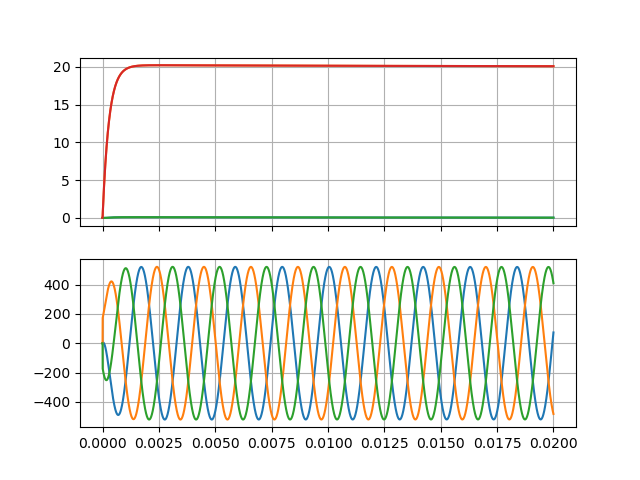

In [52]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_1['t'], Z_1['i_dqz'][:,0],label='i_d')
axes[0].plot(Z_1['t'], Z_1['i_dqz'][:,1],label='i_q')

axes[0].plot(Z_1['t'], Z_1['i_dqz_ctrl'][:,0],label='i_d')
axes[0].plot(Z_1['t'], Z_1['i_dqz_ctrl'][:,1],label='i_q')

for it in range(3):
    axes[1].plot(Z_1['t'], Z_1['v_abc'][:,it],label='v_d')


for ax in axes: ax.grid()

## Nonlinear model with fluxes as states and LUT for currents

In [53]:
data_p2i = np.load('phi2i_21.npz')

I_d_p2i,I_q_p2i = data_p2i['i_d'],data_p2i['i_q']
Phi_d_p2i,Phi_q_p2i = data_p2i['phi_d'],data_p2i['phi_q']
Theta_p2i = data_p2i['theta']

In [56]:
N_t = len(times)

phi_d = Phi_m
phi_q = 0.0
theta_r = 0.0
theta_e = 0.0
theta_t = 0.0
v_dqz = np.zeros((3))
i_dqz = np.zeros((3))

v_d,v_q = 0.0,0.0
xi_id = 0.0
xi_iq = 0.0

K_p = L_d/200e-6
T_pi = L_d/R_s

i_d_ref = 0.0
i_q_ref = 20.0


Z_5 = {'t':times}
Z_5.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z_5.update({'tau_e':np.zeros(N_t),'v_abc':np.zeros((N_t,3))})

def i_eval(theta,phi_d,phi_q):
    
    i_d = (phi_d - Phi_m)/L_d
    i_q = phi_q/L_q
    
    return i_d,i_q
    

for it,t in enumerate(times):
    
    #theta_e 0-2pi -> theta  0-30
    
    # model
    i_d,i_q = i_eval_2(phi_d,phi_q,np.rad2deg(theta_t),Phi_d_p2i,Phi_q_p2i,I_d_p2i,I_q_p2i,Theta_p2i)
    
    omega_e = omega_r*N_pp

    dtheta_r = omega_r
    dtheta_e = omega_e
    dtheta_t = omega_r
    dphi_d = (v_d - R_s*i_d - omega_e*phi_q)
    dphi_q = (v_q - R_s*i_q + omega_e*phi_d)
    tau_e = 3/2*N_pp*(phi_d*i_q - phi_q*i_d)
    
    v_dqz[0],v_dqz[1] = v_d,v_q
    i_dqz[0],i_dqz[1] = i_d,i_q
    
    v_abc = ipark_2(v_dqz,theta_e)
    i_abc = ipark_2(i_dqz,theta_e)
    
    # ctrl
    i_dqz_ctrl = park_2(i_abc,theta_e)
    i_d_ctrl,i_q_ctrl = i_dqz_ctrl[0],i_dqz_ctrl[1]
    epsilon_id = i_d_ref - i_d_ctrl
    epsilon_iq = i_q_ref - i_q_ctrl
    dxi_id = epsilon_id
    dxi_iq = epsilon_iq
    u_id = K_p*(epsilon_id + xi_id/T_pi)
    u_iq = K_p*(epsilon_iq + xi_iq/T_pi)

    v_d = u_id + omega_e*L_q*i_q_ctrl
    v_q = u_iq - omega_e*(Phi_m + L_d*i_d_ctrl)
       
    # state updates
    phi_d += Dt*dphi_d
    phi_q += Dt*dphi_q   
    theta_r += Dt*dtheta_r
    theta_e += Dt*dtheta_e
    theta_t += Dt*dtheta_t

    #update ctrl
    xi_id += Dt*dxi_id
    xi_iq += Dt*dxi_iq
    
    if theta_r>2*np.pi: theta_r = 0.0
    if theta_e>2*np.pi: theta_e = 0.0
    if theta_t>np.deg2rad(120/N_pp): theta_t = 0.0
        
    # recording
    Z_5['v_d'][it],Z_5['v_q'][it],Z_5['i_d'][it],Z_5['i_q'][it],Z_5['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    Z_5['v_abc'][it,:] = v_abc

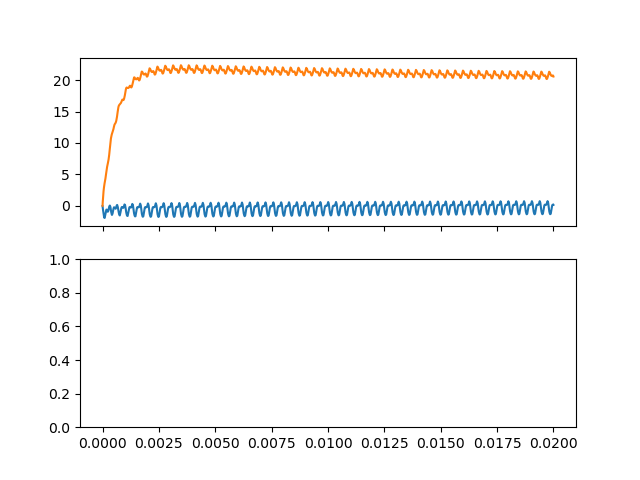

In [57]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_5['t'], Z_5['i_d'],label='$\phi$ model: i_d')
axes[0].plot(Z_5['t'], Z_5['i_q'],label='$\phi$ model: i_q')

#axes[0].plot(Z_4['t'], Z_4['i_d'],label='$\phi$ model: i_d')
#axes[0].plot(Z_4['t'], Z_4['i_q'],label='$\phi$ model: i_q')

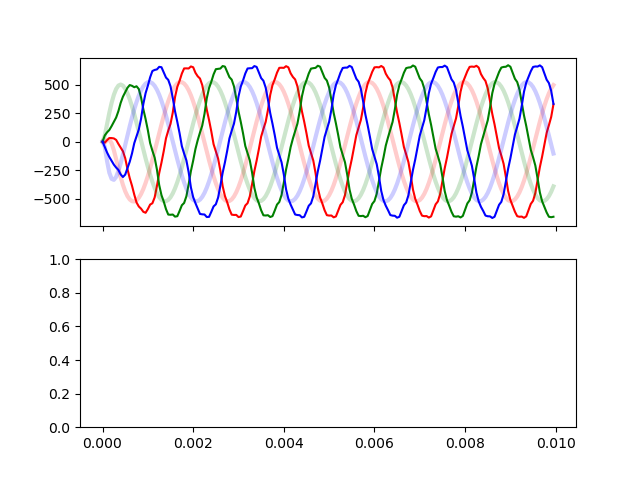

In [36]:
fig,axes = plt.subplots(nrows=2, sharex=True)

colors = ['r','g','b']
for it,item in enumerate(['v_a','v_b','v_c']):
    axes[0].plot(Z_1['t'], Z_1['v_abc'][:,it],label=item,color=colors[it],lw=3,alpha=0.2)
    axes[0].plot(Z_5['t'], Z_5['v_abc'][:,it],label=item,color=colors[it])
